In [65]:
import random
config = {
    "MutationProb": 0.2,
    "K": 10,
    "MAX_ITER": int(1e4),
    "pickMode": "wheel",
    "mutateMode": "swap",
    "seed": 2,
    "retention": 0.0,
}

Graph = [
    [0, 100, 100, 100, 100, 100, 0.15, 100, 100, 0.2, 100, 0.12, 100, 100],
    [100, 0, 100, 100, 100, 100, 100, 0.19, 0.4, 100, 100, 100, 100, 0.13],
    [100, 100, 0, 0.6, 0.22, 0.4, 100, 100, 0.2, 100, 100, 100, 100, 100,],
    [100, 100, 0.6, 0, 100, 0.21, 100, 100, 100, 100, 0.3, 100, 100, 100],
    [100, 100, 0.22, 100, 0, 100, 100, 100, 0.18, 100, 100, 100, 100, 100],
    [100, 100, 0.4, 0.21, 100, 0, 100, 100, 100, 100, 0.37, 0.6, 0.26, 0.9],
    [0.15, 100, 100, 100, 100, 100, 0, 100, 100, 100, 0.55, 0.18, 100, 100],
    [100, 0.19, 100, 100, 100, 100, 100, 0, 100, 0.56, 100, 100, 100, 0.17],
    [100, 0.4, 0.2, 100, 0.18, 100, 100, 100, 0, 100, 100, 100, 100, 0.6],
    [0.2, 100, 100, 100, 100, 100, 100, 0.56, 100, 0, 100, 0.16, 100, 0.5],
    [100, 100, 100, 0.3, 100, 0.37, 0.55, 100, 100, 100, 0, 100, 0.24, 100],
    [0.12, 100, 100, 100, 100, 0.6, 0.18, 100, 100, 0.16, 100, 0, 0.4, 100],
    [100, 100, 100, 100, 100, 0.26, 100, 100, 100, 100, 0.24, 0.4, 0, 100],
    [100, 0.13, 100, 100, 100, 0.9, 100, 0.17, 0.6, 0.5, 100, 100, 100, 0],
]


class Chromosome(list):
    def __init__(self, inputGraph, genes):
        self.graph = inputGraph
        list.__init__(self, genes)
        self.length = len(self)
        self.fitness = self.calculateFitness()

    def calculateFitness(self):
        fitness = 0
        for city in range(self.length):
            start, end = self[city], self[(city + 1) % self.length]
            fitness += self.graph[start][end]
        return fitness / self.length

    def cross(self, partner):
        child = [None] * self.length
        x, y = random.sample(range(self.length), 2)
        x, y = min(x, y), max(x, y)
        child[x:y] = self[x:y]
        order = list(reversed([gene for gene in partner if gene not in child]))
        for idx in range(self.length):
            if child[idx] is None:
                child[idx] = order.pop()
        return Chromosome(inputGraph=self.graph, genes=child)

    def mutate(self, mode="swap"):
        if mode == "swap":
            x, y = random.sample(range(self.length), 2)
            self[x], self[y] = self[y], self[x]
        elif mode == "shift":
            raise NotImplementedError
        else:
            raise NotImplementedError
        self.fitness = self.calculateFitness()

    def __str__(self):
        return f"Chromosome : {str([gene for gene in self])}, Fitness = {self.fitness}"

    def display(self):
        return (" --> ").join([chr(ord("A") + city) for city in (self + [self[0]])])


class Population:
    def __init__(self, inputGraph, k=20, chromosomes=None):

        self.graph = inputGraph
        if chromosomes is None:
            self.k = k
            self.ncities = len(self.graph)
            self.chromosomes = [
                Chromosome(self.graph, list(range(self.ncities))) for _ in range(k)
            ]
        else:
            self.k = len(chromosomes)
            self.ncities = len(self.graph)
            self.chromosomes = chromosomes

    def pick(self, mode="tournament", tournament_size=2):
        if mode == "tournament":
            participants = random.sample(self.chromosomes, tournament_size)
            return min(participants, key=lambda c: c.fitness)

        elif mode == "rank":
            return random.choices(
                population=sorted(self.chromosomes, key=lambda x: x.fitness),
                k=1,
                weights=list(range(self.k)),
            )[0]

        elif mode == "elitism":
            participants = random.choices(
                population=self.chromosomes,
                k=tournament_size,
                weights=[1 / (1e-5 + c.fitness) for c in self.chromosomes],
            )
            return random.choice(participants)

        elif mode == "wheel":
            return random.choices(
                population=self.chromosomes,
                k=1,
                weights=[1 / (1e-5 + c.fitness) for c in self.chromosomes],
            )[0]

        else:
            raise NotImplementedError

    def getMinimumFitness(self):
        return min([chromosome.fitness for chromosome in self.chromosomes])

    def getAverageFitness(self):
        return sum([chromosome.fitness for chromosome in self.chromosomes]) / self.k

    def getTopChromosome(self):
        return min(self.chromosomes, key=lambda c: c.fitness)


class GeneticAlgorithm:
    def __init__(self, inputGraph, config=config):
        self.config = config
        random.seed(self.config["seed"])
        self.graph = inputGraph
        self.history = []

    def initPool(self):
        self.pool = Population(inputGraph=self.graph, k=self.config["K"])
        self.generation = 0
        self.ncities = len(self.graph)

    def updatePool(self, retention=config["retention"]):
        newPool = []
        for _ in range(self.config["K"]):
            x, y = (
                self.pool.pick(mode=self.config["pickMode"]),
                self.pool.pick(mode=self.config["pickMode"]),
            )
            child = x.cross(y)
            if random.random() < self.config["MutationProb"]:
                child.mutate(mode=self.config["mutateMode"])
            newPool.append(child)
        newPool = (
            sorted(newPool, key=lambda c: c.fitness)[
                : int(self.config["K"] * (1 - retention))
            ]
            + self.pool.chromosomes[
                : self.config["K"] - int(self.config["K"] * (1 - retention))
            ]
        )
        self.generation += 1
        self.pool = Population(inputGraph=self.graph, chromosomes=newPool)

    def genStats(self):
        avg, minimum = (self.pool.getAverageFitness(), self.pool.getMinimumFitness())
        self.history.append(minimum)
        return avg, minimum

    def checkChange(self, n):
        if self.generation < n:
            return True
        elif len(set(self.history[-n:])) > 1:
            return True
        else:
            return False


GAFast = GeneticAlgorithm(inputGraph=Graph, config=config)
GAFast.initPool()
avFitness, minFitness = GAFast.genStats()
n_rounds = 200
solution = GAFast.pool.getTopChromosome()
print(1 /( minFitness * 14))

while GAFast.generation < GAFast.config["MAX_ITER"] and GAFast.checkChange(n_rounds):
    GAFast.updatePool(retention=GAFast.config["retention"])
    prev_min = minFitness
    avFitness, minFitness = GAFast.genStats()
    if minFitness < prev_min:
        solution = GAFast.pool.getTopChromosome()
    print(1 /( minFitness * 14))

print(
    f"Solution found in generation {GAFast.generation - n_rounds}:\n{solution.display()}\nFitness: {(1 /( minFitness * 14))}"
)

slow = [1/(14*f) for f in GAFast.history]
best = max(slow)
slow = fast[:fast.index(best)+10]

4937655860349123
0.24937655860349123
0.24937655860349123
0.24937655860349123
0.24937655860349123
0.24937655860349123
0.24937655860349123
0.24937655860349123
0.24937655860349123
0.24937655860349123
0.24937655860349123
0.24937655860349123
0.24937655860349123
0.24937655860349123
0.24937655860349123
0.24937655860349123
0.24937655860349123
0.24937655860349123
0.24937655860349123
0.24937655860349123
0.24937655860349123
0.24937655860349123
0.24937655860349123
0.24937655860349123
0.24937655860349123
0.24937655860349123
0.24937655860349123
0.24937655860349123
0.24937655860349123
0.24937655860349123
0.24937655860349123
0.24937655860349123
0.24937655860349123
0.24937655860349123
0.24937655860349123
0.24937655860349123
0.24937655860349123
0.24937655860349123
0.24937655860349123
0.24937655860349123
0.24937655860349123
0.24937655860349123
0.24937655860349123
0.24937655860349123
0.24937655860349123
0.24937655860349123
0.24937655860349123
0.24937655860349123
0.24937655860349123
0.24937655860349123
0.2

In [66]:
import random
config = {
    "MutationProb": 0.1,
    "K": 20,
    "MAX_ITER": int(1e4),
    "pickMode": "tournament",
    "mutateMode": "swap",
    "seed": 2,
    "retention": 0.0,
}

Graph = [
    [0, 100, 100, 100, 100, 100, 0.15, 100, 100, 0.2, 100, 0.12, 100, 100],
    [100, 0, 100, 100, 100, 100, 100, 0.19, 0.4, 100, 100, 100, 100, 0.13],
    [100, 100, 0, 0.6, 0.22, 0.4, 100, 100, 0.2, 100, 100, 100, 100, 100,],
    [100, 100, 0.6, 0, 100, 0.21, 100, 100, 100, 100, 0.3, 100, 100, 100],
    [100, 100, 0.22, 100, 0, 100, 100, 100, 0.18, 100, 100, 100, 100, 100],
    [100, 100, 0.4, 0.21, 100, 0, 100, 100, 100, 100, 0.37, 0.6, 0.26, 0.9],
    [0.15, 100, 100, 100, 100, 100, 0, 100, 100, 100, 0.55, 0.18, 100, 100],
    [100, 0.19, 100, 100, 100, 100, 100, 0, 100, 0.56, 100, 100, 100, 0.17],
    [100, 0.4, 0.2, 100, 0.18, 100, 100, 100, 0, 100, 100, 100, 100, 0.6],
    [0.2, 100, 100, 100, 100, 100, 100, 0.56, 100, 0, 100, 0.16, 100, 0.5],
    [100, 100, 100, 0.3, 100, 0.37, 0.55, 100, 100, 100, 0, 100, 0.24, 100],
    [0.12, 100, 100, 100, 100, 0.6, 0.18, 100, 100, 0.16, 100, 0, 0.4, 100],
    [100, 100, 100, 100, 100, 0.26, 100, 100, 100, 100, 0.24, 0.4, 0, 100],
    [100, 0.13, 100, 100, 100, 0.9, 100, 0.17, 0.6, 0.5, 100, 100, 100, 0],
]


class Chromosome(list):
    def __init__(self, inputGraph, genes):
        self.graph = inputGraph
        list.__init__(self, genes)
        self.length = len(self)
        self.fitness = self.calculateFitness()

    def calculateFitness(self):
        fitness = 0
        for city in range(self.length):
            start, end = self[city], self[(city + 1) % self.length]
            fitness += self.graph[start][end]
        return fitness / self.length

    def cross(self, partner):
        child = [None] * self.length
        x, y = random.sample(range(self.length), 2)
        x, y = min(x, y), max(x, y)
        child[x:y] = self[x:y]
        order = list(reversed([gene for gene in partner if gene not in child]))
        for idx in range(self.length):
            if child[idx] is None:
                child[idx] = order.pop()
        return Chromosome(inputGraph=self.graph, genes=child)

    def mutate(self, mode="swap"):
        if mode == "swap":
            x, y = random.sample(range(self.length), 2)
            self[x], self[y] = self[y], self[x]
        elif mode == "shift":
            raise NotImplementedError
        else:
            raise NotImplementedError
        self.fitness = self.calculateFitness()

    def __str__(self):
        return f"Chromosome : {str([gene for gene in self])}, Fitness = {self.fitness}"

    def display(self):
        return (" --> ").join([chr(ord("A") + city) for city in (self + [self[0]])])


class Population:
    def __init__(self, inputGraph, k=20, chromosomes=None):

        self.graph = inputGraph
        if chromosomes is None:
            self.k = k
            self.ncities = len(self.graph)
            self.chromosomes = [
                Chromosome(self.graph, list(range(self.ncities))) for _ in range(k)
            ]
        else:
            self.k = len(chromosomes)
            self.ncities = len(self.graph)
            self.chromosomes = chromosomes

    def pick(self, mode="tournament", tournament_size=2):
        if mode == "tournament":
            participants = random.sample(self.chromosomes, tournament_size)
            return min(participants, key=lambda c: c.fitness)

        elif mode == "rank":
            return random.choices(
                population=sorted(self.chromosomes, key=lambda x: x.fitness),
                k=1,
                weights=list(range(self.k)),
            )[0]

        elif mode == "elitism":
            participants = random.choices(
                population=self.chromosomes,
                k=tournament_size,
                weights=[1 / (1e-5 + c.fitness) for c in self.chromosomes],
            )
            return random.choice(participants)

        elif mode == "wheel":
            return random.choices(
                population=self.chromosomes,
                k=1,
                weights=[1 / (1e-5 + c.fitness) for c in self.chromosomes],
            )[0]

        else:
            raise NotImplementedError

    def getMinimumFitness(self):
        return min([chromosome.fitness for chromosome in self.chromosomes])

    def getAverageFitness(self):
        return sum([chromosome.fitness for chromosome in self.chromosomes]) / self.k

    def getTopChromosome(self):
        return min(self.chromosomes, key=lambda c: c.fitness)


class GeneticAlgorithm:
    def __init__(self, inputGraph, config=config):
        self.config = config
        random.seed(self.config["seed"])
        self.graph = inputGraph
        self.history = []

    def initPool(self):
        self.pool = Population(inputGraph=self.graph, k=self.config["K"])
        self.generation = 0
        self.ncities = len(self.graph)

    def updatePool(self, retention=config["retention"]):
        newPool = []
        for _ in range(self.config["K"]):
            x, y = (
                self.pool.pick(mode=self.config["pickMode"]),
                self.pool.pick(mode=self.config["pickMode"]),
            )
            child = x.cross(y)
            if random.random() < self.config["MutationProb"]:
                child.mutate(mode=self.config["mutateMode"])
            newPool.append(child)
        newPool = (
            sorted(newPool, key=lambda c: c.fitness)[
                : int(self.config["K"] * (1 - retention))
            ]
            + self.pool.chromosomes[
                : self.config["K"] - int(self.config["K"] * (1 - retention))
            ]
        )
        self.generation += 1
        self.pool = Population(inputGraph=self.graph, chromosomes=newPool)

    def genStats(self):
        avg, minimum = (self.pool.getAverageFitness(), self.pool.getMinimumFitness())
        self.history.append(minimum)
        return avg, minimum

    def checkChange(self, n):
        if self.generation < n:
            return True
        elif len(set(self.history[-n:])) > 1:
            return True
        else:
            return False


GAFast = GeneticAlgorithm(inputGraph=Graph, config=config)
GAFast.initPool()
avFitness, minFitness = GAFast.genStats()
n_rounds = 200
solution = GAFast.pool.getTopChromosome()
print(1 /( minFitness * 14))

while GAFast.generation < GAFast.config["MAX_ITER"] and GAFast.checkChange(n_rounds):
    GAFast.updatePool(retention=GAFast.config["retention"])
    prev_min = minFitness
    avFitness, minFitness = GAFast.genStats()
    if minFitness < prev_min:
        solution = GAFast.pool.getTopChromosome()
    print(1 /( minFitness * 14))

print(
    f"Solution found in generation {GAFast.generation - n_rounds}:\n{solution.display()}\nFitness: {(1 /( minFitness * 14))}"
)

fast = [1/(14*f) for f in GAFast.history]
best

0.0008326394671107411
0.0009986817401030639
0.0009989810393398733
0.0012468827930174561
0.0014247855697717493
0.001424055139414998
0.0016595031447584592
0.0016595031447584592
0.0016595031447584592
0.0016595031447584592
0.0016595031447584592
0.0016601367952719308
0.0016601367952719308
0.0016601367952719308
0.001987478883036868
0.001987478883036868
0.001988743710598015
0.001988743710598015
0.002479359333548211
0.002479359333548211
0.002479359333548211
0.002479359333548211
0.002479359333548211
0.002479359333548211
0.002479359333548211
0.0032964135021097043
0.0032964135021097043
0.0032964135021097043
0.0032964135021097043
0.0032964135021097043
0.0032964135021097043
0.0032964135021097043
0.0032964135021097043
0.0032964135021097043
0.0032964135021097043
0.0032964135021097043
0.0032964135021097043
0.0032964135021097043
0.0032964135021097043
0.0033021827427929863
0.0033021827427929863
0.0033021827427929863
0.0033021827427929863
0.0033021827427929863
0.0033021827427929863
0.0033021827427929863


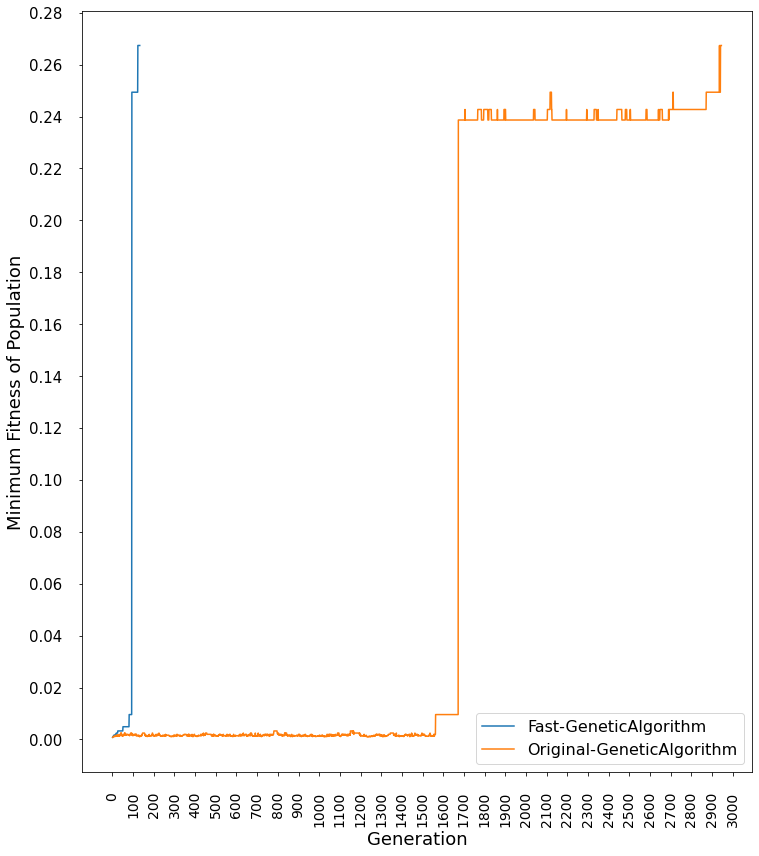

In [70]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(12,14))
plt.xticks(np.arange(0,max(len(fast), len(slow))+100,100), rotation=90, size=14)
plt.yticks(np.insize=15)
plt.ylabel("Minimum Fitness of Population", size=18)
plt.xlabel("Generation", size=18)
plt.rcParams['xtick.major.pad']='16'
plt.rcParams['ytick.major.pad']='16'
sns.lineplot(x=np.arange(len(fast))+1, y=np.asarray(fast), label="Fast-GeneticAlgorithm")
sns.lineplot(x=np.arange(len(slow))+1, y=np.asarray(slow), label="Original-GeneticAlgorithm")
plt.legend(prop={'size': 16})
plt.savefig("TravelingSalesman.pdf", dpi=1200)

In [71]:
import pickle
with open("mypickle.pickle", 'rb') as f:
    slow = pickle.load(f)

with open("mypicklefast.pickle", 'rb') as f:
    fast = pickle.load(f)

In [74]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(12,14))
plt.xticks(np.arange(0,len(slow)+100,100), rotation=90, size=14)
plt.yticks(size=15)
plt.ylabel("Minimum Fitness of Population", size=18)
plt.xlabel("Generation", size=18)
plt.rcParams['xtick.major.pad']='16'
plt.rcParams['ytick.major.pad']='16'
sns.lineplot(x=np.arange(len(fast))+1, y=np.asarray(fast), label="Improved GeneticAlgorithm")
sns.lineplot(x=np.arange(len(slow))+1, y=np.asarray(slow), label="Basic GeneticAlgorithm")
plt.legend(prop={'size': 16})
plt.savefig("Nag.pdf", dpi=1200)

SyntaxError: invalid syntax (<ipython-input-74-c2aad38d6526>, line 7)